In [12]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import multiprocessing
from joblib import Parallel, delayed
import time

In [25]:
g_filename = None
g_case_list = None
g_year_map = None

def get_file_obj(filename):
    return open(filename, 'r')

def get_year_map(filename):
    
    global g_filename
    global g_case_list
    global g_year_map
    
    if (g_filename is not None) and (g_filename == filename):
        if (g_case_list is not None) and (g_year_map is not None):
            return g_year_map, g_case_list
        
    
    f = get_file_obj(filename)
    
    year_map = {}
    case_list = []
    
    for line in f:
        year, from_case, to_case = line[:-1].split(',')
        
        if from_case not in year:
            year_map[from_case] = int(year)
            case_list.append(from_case)
        
    f.close()
    
    g_filename = filename
    g_year_map = year_map
    g_case_list = case_list
    
    
    
    return year_map, case_list


def get_graph(filename, b_enforce_random = False):
    
    if b_enforce_random:
        random_start = 0
        random_end = 5000
        random_target = random_start + (random_end - random_start) / 2
    
    year_map, case_list = get_year_map(filename)
    
    # Begin building citation graph
    f = get_file_obj(filename)    
    g = nx.DiGraph()
    
    for line in f:
    
        year, from_case, to_case = line[:-1].split(',')

        # Citing a future case is invalid
        if (to_case in year_map) and (from_case in year_map) and (year_map[from_case] < year_map[to_case]):
            continue
            
        # If they cite each other, it is most likely that both are a wrong edge
        if (to_case in g) and (from_case in g[to_case]):
            del g[to_case][from_case]
            continue
        
        # Add edges
        if (b_enforce_random == False) or (random_target == random.randrange(random_start, random_end)):
            g.add_edge(from_case, to_case)
#             g.node[from_case]['year']=int(year)
            g.node[from_case]['ifCounted']=False
            g.node[from_case]['isMemer']=False
            g.node[from_case]['citesMemer']=False
            g.node[to_case]['ifCounted']=False
            g.node[to_case]['isMemer']=False
            g.node[to_case]['citesMemer']=False
                
    f.close()
    
    return g
    

def display_graph(graph):
    
    print graph.nodes()


def topological_sort(graph):
    """
    Sorts graph by year.
    Argument: graph
    Returns: a list of nodes of the graph sorted by dependencies
    """
    
    global g_filename
    
    if g_filename is None:
        return graph.nodes()
    
    year_map, case_list = get_year_map(g_filename)
    
    return case_list

def freshen_graph(g):
    for node in g.nodes():
        g.node[node]['ifCounted']=False
        g.node[node]['isMemer']=False
        g.node[node]['citesMemer']=False
    return g

In [23]:
def gramScorer(gram,graph,gram_dict,verbose=0):
    """
    Calculates meme score for each ngram.
    Arguments:
    gram: an n-gram or phrase for which meme score to be calculated
    sorted_list: a sorted list of all nodes in graph
    graph: a NetworkX DAG of nodes/cases with edges
    gram_dict: dict storing n-grams
    Returns:
    meme_score: final meme_score of the n-gram
"""
    sorted_list = topological_sort(graph)
    graph_size = len(sorted_list) #number of nodes
    if verbose==1:
        print "graph_size is",graph_size
    dm2m=0
    d2m=0
    dm2n=0
    d2n=0
    memers=0
    nonmemers=0
    
    
    #every node stores 3 vars - isMemer, citesMemer, ifCounted (in sum)
    
    for node in sorted_list: #list of nodes sorted topologically
        if not graph.node[node]['ifCounted']: #if not counted in sum
            
            if verbose==2:
                print node,graph.node[node]
            if node in gram_dict.keys():

                if gram_dict[node].has_key(gram): #if gram present
                    memers+=1 #has meme
                    graph.node[node]['isMemer']=True

                else:
                    nonmemers+=1

            graph.node[node]['ifCounted']=True


            if len(graph.successors(node))>0: #has children (citers)
                for child in graph.successors_iter(node):

                    if graph.node[child]['isMemer']==True: #soft-check if child has gram
                        graph.node[node]['citesMemer']=True
                    elif gram_dict[child].has_key(gram): #hard-check using dictionary
                        graph.node[child]['isMemer']=True
                        graph.node[node]['citesMemer']=True
                        break

            if verbose==2:
                print node,graph.node[node]
            if graph.node[node]['isMemer']==True and graph.node[node]['citesMemer']==True:
                dm2m+=1 #memer cites memer

            elif graph.node[node]['isMemer']==True and graph.node[node]['citesMemer']==False:
                if len(graph.successors(node))!=0: #make sure childless nodes not counted
                    dm2n+=1 #memer cites non-memers

            if graph.node[node]['citesMemer']==True:
                d2m+=1 #cites memers

            elif graph.node[node]['citesMemer']==False:
                if len(graph.successors(node))!=0: #make sure childless nodes not counted
                    d2n+=1 #cites non-memers

    assert memers+nonmemers==graph_size #sanity check for memer size
    if verbose==1:
        print "memers =",memers
        print "nonmemers =",nonmemers
        print "dm2m =",dm2m
        print "d2m =",d2m
        print "dm2n =",dm2n
        print "d2n =",d2n

    prop_score = (float(dm2m)/(d2m+3.))/((dm2n+3.)/(d2n+3.)) #ratio of sticking factor by sparking factor
    #we take a shifted prop. score to make sure score not infinite
    freq = float(memers)/(graph_size) #ratio of # of memers for that n-gram to size of graph
    meme_score = prop_score*freq #prop_score x meme frequency
    
    if verbose==1:
        print "prop_score =",prop_score
        print "freq =",freq
        print "meme_score =",meme_score

    return meme_score

In [4]:
edges_with_cycles=[('A','B'),('A','C'),('B','A'),('G','E'),
       ('B','F'),('B','E'),
       ('E','F'),('E','G'),
       ('C','D'),('C','H'),
       ('G','H'),
       ('D','H'),
       ('F','H')]

#cycles are ('B','A'),('G','E') in 1st row.

normal_edges=[('A','B'),('A','C'),
       ('B','F'),('B','E'),
       ('E','F'),('E','G'),
       ('C','D'),('C','H'),
       ('G','H'),
       ('D','H'),
       ('F','H')]

In [5]:
test_dict={'A':{'test1':2,'test2':2,'test3':3},'B':{'test2':2,'test3':3},'C':{'test1':2,'test2':1,'test3':3},
           'D':{'test1':2,'test3':3},'E':{'test1':2,'test2':1},'F':{'test2':1,'test3':3},
           'G':{'test1':2,'test2':1},'H':{'test2':1,'test3':2}}

In [15]:
def build_test_graph(edges):
    g = nx.DiGraph()
    for x in edges:
        g.add_edge(x[0], x[1])
        g.node[x[0]]['ifCounted']=False
        g.node[x[0]]['isMemer']=False
        g.node[x[0]]['citesMemer']=False
        g.node[x[1]]['ifCounted']=False
        g.node[x[1]]['isMemer']=False
        g.node[x[1]]['citesMemer']=False
    return g

def freshen_graph(g):
    for node in g.nodes():
        g.node[node]['ifCounted']=False
        g.node[node]['isMemer']=False
        g.node[node]['citesMemer']=False
    return g

## Testing cycles

In [7]:
g_cycle=build_test_graph(edges_with_cycles)
g_norm = build_test_graph(normal_edges)

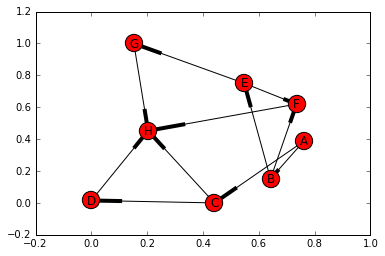

In [8]:
nx.draw_networkx(g_norm)

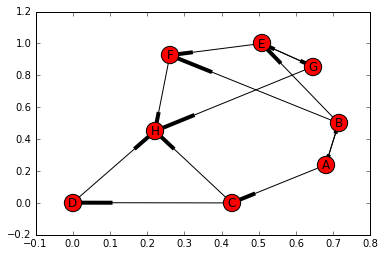

In [9]:
nx.draw_networkx(g_cycle)

In [10]:
# h_cycle=eliminate_cycles(g_cycle)
# nx.draw_networkx(h_cycle)

[['E', 'F', 'B'],
 ['C', 'H', 'F', 'B', 'A'],
 ['E', 'G', 'H', 'F'],
 ['C', 'D', 'H']]

In [11]:
[edge for edge in g_cycle.edges() if edge not in h_cycle.edges()]

NameError: name 'h_cycle' is not defined

### @adi: Some non-cycle edges are missing above!

## Testing meme-scorer

In [15]:
# gram = test1
# A, y -> B, C, m2m = 1, 2m = 1, m2n = 0, 2n = 0 [0=no, 1=yes]
# B, n -> F, E, m2m = 0, 2m = 1, m2n = 0, 2n = 0 
# C, y -> D, H, m2m = 1, 2m = 1, m2n = 0, 2n = 0
# D, y -> H,    m2m = 0, 2m = 0, m2n = 1, 2n = 1
# E, y -> F, G, m2m = 1, 2m = 1, m2n = 0, 2n = 0
# F, n -> H,    m2m = 0, 2m = 0, m2n = 0, 2n = 1
# G, y -> H,    m2m = 0, 2m = 0, m2n = 1, 2n = 1
# H, n -> na,   m2m = 0, 2m = 0, m2n = 0, 2n = 0

In [22]:
#node: A, gram: test1. Check that following should be correct:
# memers=    5
# nonmemers= 3
# dm2m =     3
# d2m =      4
# dm2n =     2
# d2n =      3

In [26]:
# testg = build_test_graph()
for i in ['A']:
    for gram in test_dict[i]:
        print i,gram
        testg=freshen_graph(g_norm)
        dummy_score=gramScorer(gram,g_norm,test_dict,1)
        

A test1
graph_size is 8
memers = 5
nonmemers = 3
dm2m = 3
d2m = 4
dm2n = 2
d2n = 3
prop_score = 0.514285714286
freq = 0.625
meme_score = 0.321428571429
A test3
graph_size is 8
memers = 6
nonmemers = 2
dm2m = 5
d2m = 7
dm2n = 0
d2n = 0
prop_score = 0.5
freq = 0.75
meme_score = 0.375
A test2
graph_size is 8
memers = 7
nonmemers = 1
dm2m = 6
d2m = 7
dm2n = 0
d2n = 0
prop_score = 0.6
freq = 0.875
meme_score = 0.525


### Result: Correct.